This is the Final ONE , other is just a try to generic the code 

In [1]:
import onnx
import netron
model_path = "/home/AAt_switch/ACASXU_run2a_2_2_batch_2000.onnx"  # Update with the correct path
model = onnx.load(model_path)
onnx.checker.check_model(model)
netron.start(model_path)


ModuleNotFoundError: No module named 'onnx'

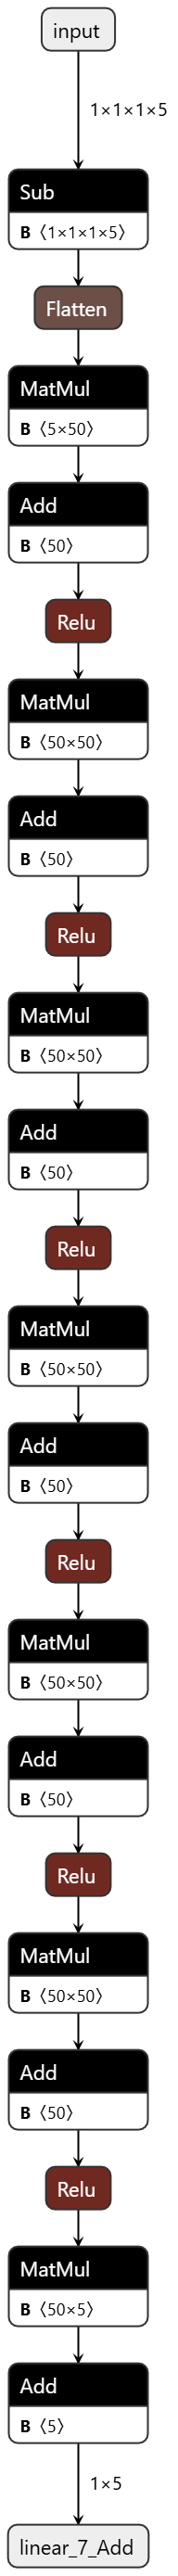

In [ ]:
from IPython.display import Image, display
display(Image('/home/indrajit/AAt_switch/svpasg/_home_AAt_switch_ACASXU_run2a_2_2_batch_2000.png'))

In [ ]:
import onnx
import numpy as np
from z3 import *
import re
from onnx import numpy_helper

class NNVerifier:
    def __init__(self):
        self.solver = Solver()
        self.variables = {}
        self.m=0
        
    def read_onnx(self, onnx_path):
        model = onnx.load(onnx_path)
        self.input_shape = None
        self.output_shape = None
        for input in model.graph.input:
            dims = [dim.dim_value for dim in input.type.tensor_type.shape.dim]
            self.input_shape = dims
            
        for output in model.graph.output:
            dims = [dim.dim_value for dim in output.type.tensor_type.shape.dim]
            self.output_shape = dims
            
        return model

    def create_variables(self, layer_sizes):
        for i, size in enumerate(layer_sizes):
            layer_vars = []
            for j in range(size):
                var = Real(f'x_{i}_{j}')
                layer_vars.append(var)
            self.variables[i] = layer_vars

    def add_layer_constraints(self, weights, biases, input_layer, output_layer):
        input_vars = self.variables[input_layer]
        output_vars = self.variables[output_layer]
        
        
        # for i in range(len(output_vars)):
        #     expr = biases[i]
        #     for j in range(len(input_vars)):
        #         expr += weights[i][j] * input_vars[j]
        for j in range(len(output_vars)):
            expr = sum(weights[k][j] * input_vars[k] for k in range(len(input_vars))) + biases[j]
            self.solver.add(output_vars[j] == expr)
            self.m+=1
        print("success")
        print(self.m)

    def add_relu_constraints(self, layer):
        vars = self.variables[layer]
        for var in vars:
            # ReLU(x) = max(0,x)
            relu_var = Real(f'relu_{var}')
            self.solver.add(relu_var >= 0)
            self.solver.add(relu_var >= var)
            self.solver.add(Or(relu_var == 0, relu_var == var))

    def parse_vnnlib(self, vnnlib_path):
        with open(vnnlib_path, 'r') as f:
            content = f.read()
            
        
        input_constraints = []
        
        input_vars = re.findall(r'\(declare-const (X_\d+) Real\)', content)
        
        
        bounds = re.findall(r'\(assert \(([<>=]+) (X_\d+) ([-\d.]+)\)\)', content)
        
        for op, var, val in bounds:
            var_idx = int(var.split('_')[1])
            val = float(val)
            if op == '<=':
                self.solver.add(self.variables[0][var_idx] <= val)
            elif op == '>=':
                self.solver.add(self.variables[0][var_idx] >= val)
            elif op == '=':
                self.solver.add(self.variables[0][var_idx] == val)
            print("success12")



    def property_expr(self, vnnlib_path,layer_sizes):

        with open(vnnlib_path, 'r') as f:
            content = f.read()
            
        
        out_constraints = []
       
        out_vars = re.findall(r'\(declare-const (Y_\d+) Real\)', content)
        
       
        bounds1 = re.findall(r'\(assert \(([<>=]+) (Y_\d+) ([-\d.]+)\)\)', content)
        l=len(layer_sizes)
        for op, var, val in bounds1:
            var_idx = int(var.split('_')[1])
            val = float(val)
            if op == '<=':
                return self.variables[l-1][var_idx] <= val
            elif op == '>=':
                return self.variables[l-1][var_idx] >= val
            elif op == '=':
                return self.variables[l-1][var_idx] == val

    def verify_property(self, property_expr):
        self.solver.push()
        self.solver.add(property_expr)
        
        result = self.solver.check()
        if result == sat:
            model = self.solver.model()
            self.solver.pop()
            return False, model
        else:
            self.solver.pop()
            return True, None

def main():
    verifier = NNVerifier()
    
    # Read ONNX model
    model = verifier.read_onnx("/home/AAt_switch/svpasg/ACASXU_run2a_2_2_batch_2000.onnx")
    # Create variables for each layer
    layer_sizes = [5, 50, 50, 50, 50, 50, 50, 5]  
    verifier.create_variables(layer_sizes)
    weights = []
    biases = []
    for initializer in model.graph.initializer:
        
        np_array = numpy_helper.to_array(initializer)
        
        
        if len(np_array.shape) == 2:  
            weights.append(np_array)
        elif len(np_array.shape) == 1:  
            biases.append(np_array)
    for i in range(len(layer_sizes)-1):
        weights1 =weights[i] 
        biases1 = biases[i]   
        verifier.add_layer_constraints(weights1, biases1, i, i+1)
        if i < len(layer_sizes)-2:  # Exc ReLU after last layer
            verifier.add_relu_constraints(i+1)





    
    ##Testing
    # for i in range(len(layer_sizes)-1):
    #     weights = np.random.rand(layer_sizes[i+1], layer_sizes[i])  # Replace with actual weights
    #     biases = np.zeros(layer_sizes[i+1])  # Replace with actual biases
    #     verifier.add_layer_constraints(weights, biases, i, i+1)
    #     if i < len(layer_sizes)-2:  # Don't add ReLU after last layer
    #         verifier.add_relu_constraints(i+1)
    
    
    verifier.parse_vnnlib("/home/AAt_switch/svpasg/prop_1.vnnlib")
    

    property_expr = verifier.property_expr( "/home/indrajit/AAt_switch/svpasg/prop_1.vnnlib",layer_sizes)
    verified, counterexample = verifier.verify_property(property_expr)
    
    if verified:
        print("Property verified!")
    else:
        print("Property violated! Counterexample found:")
        print(counterexample)

if __name__ == "__main__":
    main()

success
50
success
100
success
150
success
200
success
250
success
300
success
305
success12
success12
success12
success12
success12
success12
success12
success12
success12
success12
Property verified!
